<span style="font-size:50px"><strong>ML4HC Project 1 - Task 3</strong></span>


In [3]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score


# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)


# Transformer Model - Q2.3

### Model and training loop

In [4]:
class Transformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=1, max_len=49,dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, F)
        x = self.input_proj(x)                     # -> (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1)]  # add position info
        x = self.transformer(x)                    # -> (B, T, D)
        x = x.mean(dim=1)                          # average pooling
        return self.cls_head(x).squeeze(-1)


In [5]:
def train_transformer(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, weight_decay=0.0, device="cuda" if torch.cuda.is_available() else "cpu", checkpoint_path="best_model.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_auroc": [], "val_auprc": []}
    best_auroc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["train_loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

        if val_dataloader:
            auroc, auprc, val_loss = evaluate_transformer(model, val_dataloader, device)
            history["val_loss"].append(val_loss)
            history["val_auroc"].append(auroc)
            history["val_auprc"].append(auprc)
            print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")

            if auroc > best_auroc:
                best_auroc = auroc
                best_state = model.state_dict()

    if best_state:
        torch.save(best_state, checkpoint_path)
        print(f"✅ Best model saved with AUROC = {best_auroc:.4f} at {checkpoint_path}")

    plot_training_curves(history)
    return history

In [6]:

def plot_training_curves(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    if history["val_loss"]:
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["val_auroc"], label="AUROC")
    plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("Validation AUROC")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["val_auprc"], label="AUPRC")
    plt.xlabel("Epoch"); plt.ylabel("AUPRC"); plt.title("Validation AUPRC")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [7]:

def evaluate_transformer(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)
    val_loss = total_loss / len(dataloader)

    print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")
    return auroc, auprc, val_loss


In [8]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")

    df = df.sort_values(by=["RecordID", "Time"])

    # Move RecordID and Time to the front
    cols = ["RecordID", "Time"] + [col for col in df.columns if col not in ["RecordID", "Time"]]
    df = df[cols]

    # Remove label from features
    features = [col for col in df.columns if col not in ["RecordID", "Time", "In-hospital_death"]]

    # Group time series per patient
    grouped = df.groupby("RecordID")[features].apply(lambda x: x.to_numpy()).tolist()
    assert all(x.shape == (49, 40) for x in grouped), "Not all patients have shape (49, 41)"

    # Convert to tensor
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in grouped])  # (N, 49, 41)

    # Extract labels
    y = torch.tensor(df.groupby("RecordID")["In-hospital_death"].first().values, dtype=torch.float32)

    dataset = TensorDataset(X, y) 
    return dataset


### Testing

In [9]:
train_dataset = get_data("train")
val_dataset = get_data("val")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



Epoch 1/5 - Train Loss: 0.4094
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Epoch 2/5 - Train Loss: 0.4046
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Epoch 3/5 - Train Loss: 0.3672
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Epoch 4/5 - Train Loss: 0.3446
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Epoch 5/5 - Train Loss: 0.3503
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
✅ Best model saved with AUROC = 0.7892 at best_model.pt


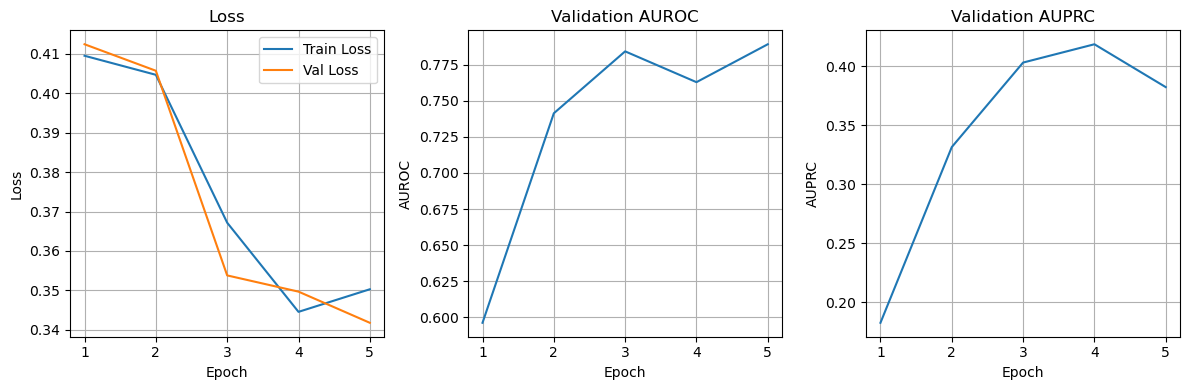

{'train_loss': [0.4094467160701752,
  0.40462010848522184,
  0.36716575968265536,
  0.34458487820625305,
  0.3503050824403763],
 'val_loss': [0.4123578779697418,
  0.40564864790439603,
  0.3538136981725693,
  0.3497051717042923,
  0.3418138462305069],
 'val_auroc': [np.float64(0.5962248945303523),
  np.float64(0.7413639031156637),
  np.float64(0.7842617329853245),
  np.float64(0.7629238792310976),
  np.float64(0.7891830513969598)],
 'val_auprc': [np.float64(0.18271350756548826),
  np.float64(0.33153975312727424),
  np.float64(0.403123651585671),
  np.float64(0.41862391250915715),
  np.float64(0.38232661613787056)]}

In [10]:
model = Transformer(input_dim=40, model_dim=64, num_layers=3, dropout=0.1)


train_transformer(model, train_loader, val_dataloader=val_loader, epochs=5, lr=1e-3)

## Q2.3b: Tokenizing Time-Series Data and Transformers 

In [11]:
df = pd.read_parquet(f"data_a_scaled_nonImputed.parquet")
df["Time"] = df["Time"] / df["Time"].max()


In [12]:
df

,Time,RecordID,Age,Gender,Height,ICUType,Weight,BUN,Creatinine,GCS,Glucose,HCO3,HCT,HR,K,Mg,NIDiasABP,NIMAP,NISysABP,Na,Platelets,RespRate,Temp,TroponinT,Urine,WBC,ALP,ALT,AST,Albumin,Bilirubin,FiO2,PaCO2,PaO2,pH,DiasABP,MAP,SaO2,SysABP,Lactate,Cholesterol,TroponinI,In-hospital_death
0,0.000000,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.020833,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.041667,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,0.905372,NaN,NaN,NaN,1.420996,NaN,NaN,-1.014629,-0.570817,0.029915,NaN,NaN,0.426204,-0.608415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.062500,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,1.627492,1.053339,NaN,4.182595,-2.574523,-1.037699,1.477224,1.664938,1.745415,-0.346486,-0.030079,0.216447,0.179207,0.964105,0.243589,NaN,-0.300136,0.272988,0.56182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.083333,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,1.420996,NaN,NaN,-0.680558,-0.391022,-0.063351,NaN,NaN,0.791436,NaN,NaN,0.075019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,0.916667,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.465118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.594195,1.406126,NaN,1.331414,NaN,NaN,NaN,0
195996,0.937500,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,0.905372,NaN,NaN,NaN,0.408890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337238,NaN,0.317015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.772969,1.529577,NaN,1.375968,NaN,NaN,NaN,0
195997,0.958333,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.858715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.831144,1.159226,NaN,1.465077,NaN,NaN,NaN,0
195998,0.979167,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.690031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876725,0.480249,NaN,0.484884,NaN,NaN,NaN,0


In [38]:
df = pd.read_parquet(f"data_a_scaled_nonImputed.parquet")
df["Time"] = df["Time"] / df["Time"].max()
df = df.melt(id_vars=["RecordID", "Time"], var_name="Variable", value_name="Value")
df = df[["RecordID", "Time", "Variable", "Value"]].reset_index(drop=True)

# Drop ICUType
df = df[df["Variable"] != "ICUType"]

# For Gender, Age, Height — keep only row with smallest time per RecordID
mask = df["Variable"].isin(["Gender", "Age", "Height", "In-hospital_death"])
df = df[~mask | df.groupby(["RecordID", "Variable"])["Time"].transform("min").eq(df["Time"])]
df = df.sort_values(by=["RecordID", "Time"]).reset_index(drop=True)
df = df.dropna(subset=["Value"]).reset_index(drop=True)

# Create target dataframe y with one row per RecordID
y = df[df["Variable"] == "In-hospital_death"][["RecordID", "Value"]].copy()
y = y.rename(columns={"Value": "In-hospital_death"}).set_index("RecordID")

# Remove In-hospital_death rows from df
df = df[df["Variable"] != "In-hospital_death"].reset_index(drop=True)


df.head(10)

,RecordID,Time,Variable,Value
0,132539.0,0.000000,Age,-0.583612
1,132539.0,0.000000,Gender,0.000000
2,132539.0,0.020833,GCS,0.905372
3,132539.0,0.020833,HR,-0.546987
4,132539.0,0.020833,NIDiasABP,-0.012415
5,132539.0,0.020833,NIMAP,0.938519
6,132539.0,0.020833,NISysABP,1.755339
7,132539.0,0.020833,RespRate,-0.121643
8,132539.0,0.020833,Temp,-1.790481
9,132539.0,0.020833,Urine,0.075019


In [39]:
df = pd.get_dummies(df, columns=["Variable"],dtype=int)
df.head(10)

,RecordID,Time,Value,Variable_ALP,Variable_ALT,Variable_AST,Variable_Age,Variable_Albumin,Variable_BUN,Variable_Bilirubin,Variable_Cholesterol,Variable_Creatinine,Variable_DiasABP,Variable_FiO2,Variable_GCS,Variable_Gender,Variable_Glucose,Variable_HCO3,Variable_HCT,Variable_HR,Variable_Height,Variable_K,Variable_Lactate,Variable_MAP,Variable_Mg,Variable_NIDiasABP,Variable_NIMAP,Variable_NISysABP,Variable_Na,Variable_PaCO2,Variable_PaO2,Variable_Platelets,Variable_RespRate,Variable_SaO2,Variable_SysABP,Variable_Temp,Variable_TroponinI,Variable_TroponinT,Variable_Urine,Variable_WBC,Variable_Weight,Variable_pH
0,132539.0,0.000000,-0.583612,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,132539.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,132539.0,0.020833,0.905372,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,132539.0,0.020833,-0.546987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,132539.0,0.020833,-0.012415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,132539.0,0.020833,0.938519,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,132539.0,0.020833,1.755339,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,132539.0,0.020833,-0.121643,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,132539.0,0.020833,-1.790481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,132539.0,0.020833,0.075019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df.columns.difference(["RecordID", "Time"]).unique()
Gender Age. Height. ICUType, In-hospital_death. 

Index(['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin',
       'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender',
       'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType',
       'In-hospital_death', 'K', 'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP',
       'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2',
       'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight',
       'pH'],
      dtype='object')

#  Pretraining and linear probes - Q3.1

#  Simulate label scarcity - Q3.2

#  Visualising learned representations - Q3.3
